# Quarter-Mile Race from Standing Start: RWD vs AWD
This notebook simulates a standing-start quarter-mile race (402.336 m) between two cars with configurable advanced powertrains.
## What you can customize per car
- Powertrain type (`ICE`, `BEV`)
- Weight (`mass`), drivetrain (`RWD` or `AWD`), tires, and aero
- ICE torque curve, gear ratios, final drive, and shift behavior
- Manual shift time with zero wheel power during shifts
- Powertrain and driveline efficiencies so wheel power is always below source power
The notebook includes:
- Acceleration behavior comparison
- Speed vs Time plot
- Distance vs Time plot

In [206]:
import numpy as np
import matplotlib.pyplot as plt
# Constants
g = 9.81                     # m/s^2
rho_air = 1.225             # kg/m^3
quarter_mile_m = 402.336    # m
# Time integration step
dt = 0.01

In [ ]:
# Single place to customize both cars using a consistent typed schema
# Car: name + vehicle + powertrain
# Powertrain: type + driving_axles + motors + gearbox + efficiency
# Motor: rpm bounds + torque curve
# Gearbox: type + ratios/shift rules

car_specs = {
    "RWD Car": {
        "name": "RWD Car",
        "vehicle": {
            "mass": 1500,
            "CdA": 0.66,
            "wheel_radius_m": 0.335,
            "rolling_resistance": 0.015,
            "tire": {
                "width_mm": 300,
                "compound": "summer",
                "base_mu": 1.10
            }
        },
        "powertrain": {
            "type": "ICE",
            "driving_axles": "RWD",
            "efficiency": {
                "engine": 1.0,
                "driveline": 0.90
            },
            "motors": [
                {
                    "name": "ICE Engine",
                    "min_rpm": 900,
                    "max_rpm": 7200,
                    "torque_curve_rpm_nm": [[1000, 380], [2000, 570], [3000, 860], [4000, 850], [5000, 850], [6000, 750], [7000, 690]]
                }
            ],
            "gearbox": {
                "type": "manual",
                "gear_ratios": [3.10, 2.10, 1.55, 1.22, 1.00, 0.82],
                "final_drive": 3.73,
                "launch_rpm": 2800,
                "shift_rpm": 6900,
                "shift_time_s": 0.50
            }
        }
    },
    "AWD Car": {
        "name": "AWD Car",
        "vehicle": {
            "mass": 2400,
            "CdA": 0.68,
            "wheel_radius_m": 0.350,
            "rolling_resistance": 0.016,
            "tire": {
                "width_mm": 300,
                "compound": "summer",
                "base_mu": 1.05
            }
        },
        "powertrain": {
            "type": "BEV",
            "driving_axles": "AWD",
            "efficiency": {
                "motor": 1.0,
                "inverter": 0.96
            },
            "motors": [
                {
                    "name": "Combined eMotors",
                    "min_rpm": 0,
                    "max_rpm": 16000,
                    "torque_curve_rpm_nm": [[0, 900], [2000, 900], [5000, 900], [8000, 850], [12000, 700], [16000, 600]]
                }
            ],
            "gearbox": {
                "type": "single_speed",
                "ratio": 9.0
            }
        }
    }
}

In [208]:
# --- Advanced physics/model functions ---
DRIVETRAIN_BASE = {"RWD": {"drive_factor": 0.93}, "AWD": {"drive_factor": 1.00}}
TIRE_COMPOUND_GRIP = {"all_season": 0.95, "summer": 1.00, "track": 1.08, "drag_radial": 1.15}

def tire_grip_multiplier(tire_width_mm, tire_compound="summer"):
    width_factor = (tire_width_mm / 245.0) ** 0.30
    width_factor = float(np.clip(width_factor, 0.90, 1.18))
    return width_factor * TIRE_COMPOUND_GRIP.get(tire_compound, 1.00)

def interp_curve(curve_points, x_value):
    points = np.array(curve_points, dtype=float)
    return float(np.interp(x_value, points[:, 0], points[:, 1]))

def wheel_rpm_from_speed(v, wheel_radius_m):
    return (v / max(wheel_radius_m, 0.2)) * 60.0 / (2.0 * np.pi)

def get_gear_ratio(car, gear_index):
    ratios = car["ice"]["gear_ratios"]
    idx = int(np.clip(gear_index, 0, len(ratios) - 1))
    return ratios[idx]

def make_car(name, spec):
    vehicle = spec["vehicle"]
    tire = vehicle["tire"]
    powertrain = spec["powertrain"]

    drivetrain = powertrain["driving_axles"].upper()
    tire_factor = tire_grip_multiplier(tire["width_mm"], tire.get("compound", "summer"))

    car = {
        "name": spec.get("name", name),
        "powertrain_type": powertrain["type"].upper(),
        "mass": float(vehicle["mass"]),
        "drivetrain": drivetrain,
        "CdA": float(vehicle["CdA"]),
        "wheel_radius_m": float(vehicle.get("wheel_radius_m", 0.34)),
        "rolling_resistance": float(vehicle.get("rolling_resistance", 0.015)),
        "mu": float(tire.get("base_mu", 1.05)) * tire_factor,
        "drive_factor": DRIVETRAIN_BASE[drivetrain]["drive_factor"],
        "tire_width_mm": float(tire["width_mm"]),
        "tire_compound": tire.get("compound", "summer")
    }

    motors = powertrain.get("motors", [])
    gearbox = powertrain.get("gearbox", {})
    efficiency = powertrain.get("efficiency", {})

    if car["powertrain_type"] == "ICE":
        engine = motors[0]
        ice = {
            "gearbox_type": gearbox.get("type", "auto").lower(),
            "gear_ratios": [float(x) for x in gearbox.get("gear_ratios", [3.0, 2.0, 1.4, 1.0])],
            "final_drive": float(gearbox.get("final_drive", 3.5)),
            "idle_rpm": float(engine.get("min_rpm", 900)),
            "launch_rpm": float(gearbox.get("launch_rpm", engine.get("min_rpm", 900))),
            "shift_rpm": float(gearbox.get("shift_rpm", engine.get("max_rpm", 7000))),
            "redline_rpm": float(engine.get("max_rpm", 7000)),
            "shift_time_s": float(gearbox.get("shift_time_s", 0.30)),
            "engine_efficiency": float(efficiency.get("engine", 0.36)),
            "driveline_efficiency": float(efficiency.get("driveline", 0.90)),
            "torque_curve_rpm_nm": engine["torque_curve_rpm_nm"]
        }
        car["ice"] = ice

    if car["powertrain_type"] == "BEV":
        motor = motors[0]
        motor_cfg = {
            "single_speed_ratio": float(gearbox.get("ratio", 9.0)),
            "max_rpm": float(motor.get("max_rpm", 18000)),
            "motor_efficiency": float(efficiency.get("motor", 0.92)),
            "inverter_efficiency": float(efficiency.get("inverter", 0.96)),
            "torque_curve_rpm_nm": motor["torque_curve_rpm_nm"]
        }
        car["motor"] = motor_cfg

    return car

cars = {name: make_car(name, spec) for name, spec in car_specs.items()}

def initialize_state(car):
    return {"gear_index": 0, "in_shift": False, "shift_timer_s": 0.0, "pending_gear_index": 0, "shift_count": 0, "engine_rpm": 0.0, "motor_rpm": 0.0}

def ice_drive_force(v, car, state):
    ice = car["ice"]
    ratio = get_gear_ratio(car, state["gear_index"])
    fd = ice["final_drive"]
    engine_rpm = wheel_rpm_from_speed(v, car["wheel_radius_m"]) * ratio * fd
    if v < 1.5:
        engine_rpm = max(engine_rpm, ice["launch_rpm"])
    else:
        engine_rpm = max(engine_rpm, ice["idle_rpm"])
    engine_rpm = min(engine_rpm, ice["redline_rpm"])
    state["engine_rpm"] = engine_rpm
    engine_torque = interp_curve(ice["torque_curve_rpm_nm"], engine_rpm)
    wheel_torque = engine_torque * ratio * fd * ice["engine_efficiency"] * ice["driveline_efficiency"]
    return wheel_torque / max(car["wheel_radius_m"], 0.2)

def motor_drive_force(v, car, state):
    motor = car["motor"]
    ratio = motor["single_speed_ratio"]
    motor_rpm = wheel_rpm_from_speed(v, car["wheel_radius_m"]) * ratio
    motor_rpm = min(motor_rpm, motor["max_rpm"])
    state["motor_rpm"] = motor_rpm
    motor_torque = interp_curve(motor["torque_curve_rpm_nm"], motor_rpm)
    wheel_torque = motor_torque * ratio * motor["motor_efficiency"] * motor["inverter_efficiency"]
    return wheel_torque / max(car["wheel_radius_m"], 0.2)

def maybe_schedule_shift(v, car, state):
    if "ice" not in car:
        return
    ice = car["ice"]
    ratios = ice["gear_ratios"]
    if state["in_shift"]:
        return
    if state["gear_index"] >= len(ratios) - 1:
        return
    if state["engine_rpm"] >= ice["shift_rpm"]:
        state["pending_gear_index"] = state["gear_index"] + 1
        gearbox_type = ice["gearbox_type"]
        if gearbox_type == "manual":
            state["in_shift"] = True
            state["shift_timer_s"] = ice["shift_time_s"]
            state["shift_count"] += 1
        else:
            state["gear_index"] = state["pending_gear_index"]
            state["shift_count"] += 1

def propulsion_force(v, car, state, dt_step):
    if car["powertrain_type"] == "ICE":
        if state["in_shift"]:
            state["shift_timer_s"] -= dt_step
            if state["shift_timer_s"] <= 0.0:
                state["in_shift"] = False
                state["gear_index"] = state["pending_gear_index"]
            return 0.0
        force = ice_drive_force(v, car, state)
        maybe_schedule_shift(v, car, state)
        return force
    if car["powertrain_type"] == "BEV":
        return motor_drive_force(v, car, state)
    return 0.0

def acceleration_and_state(v, car, state, dt_step):
    drive_force = propulsion_force(v, car, state, dt_step)
    traction_force_max = car["mu"] * car["mass"] * g * car["drive_factor"]
    usable_force = min(drive_force, traction_force_max)
    drag_force = 0.5 * rho_air * car["CdA"] * v**2
    rolling_force = car["rolling_resistance"] * car["mass"] * g
    net_force = usable_force - drag_force - rolling_force
    return net_force / car["mass"]

def simulate_quarter_mile(car, dt=0.01, distance_target=quarter_mile_m):
    t = 0.0
    x = 0.0
    v = 0.0
    state = initialize_state(car)
    times = [t]
    distances = [x]
    speeds = [v]
    accels = [0.0]
    gears = [state["gear_index"] + 1]
    engine_rpms = [0.0]
    motor_rpms = [0.0]
    wheel_torques = [0.0]
    while x < distance_target and t <= 60.0:
        a = acceleration_and_state(v, car, state, dt)
        if car["powertrain_type"] == "ICE":
            ice = car["ice"]
            ratio = get_gear_ratio(car, state["gear_index"])
            fd = ice["final_drive"]
            engine_torque = interp_curve(ice["torque_curve_rpm_nm"], state["engine_rpm"])
            wheel_torque = engine_torque * ratio * fd * ice["engine_efficiency"] * ice["driveline_efficiency"]
        elif car["powertrain_type"] == "BEV":
            motor = car["motor"]
            ratio = motor["single_speed_ratio"]
            motor_torque = interp_curve(motor["torque_curve_rpm_nm"], state["motor_rpm"])
            wheel_torque = motor_torque * ratio * motor["motor_efficiency"] * motor["inverter_efficiency"]
        else:
            wheel_torque = 0.0
        v = max(0.0, v + a * dt)
        x = x + v * dt
        t = t + dt
        times.append(t)
        distances.append(x)
        speeds.append(v)
        accels.append(a)
        gears.append(state["gear_index"] + 1)
        engine_rpms.append(state["engine_rpm"])
        motor_rpms.append(state["motor_rpm"])
        wheel_torques.append(wheel_torque)
    return {
        "time": np.array(times),
        "distance": np.array(distances),
        "speed": np.array(speeds),
        "accel": np.array(accels),
        "gear": np.array(gears),
        "engine_rpm": np.array(engine_rpms),
        "motor_rpm": np.array(motor_rpms),
        "wheel_torque": np.array(wheel_torques),
        "elapsed_time": t,
        "trap_speed": v,
        "shift_count": state["shift_count"]
    }

In [209]:
results = {name: simulate_quarter_mile(spec, dt=dt) for name, spec in cars.items()}
for name, r in results.items():
    car = cars[name]
    summary = f"{name} | {car['powertrain_type']} | {car['drivetrain']} | {car['tire_width_mm']:.0f}mm {car['tire_compound']}"
    if car['powertrain_type'] == 'ICE':
        summary += f" | {car['ice']['gearbox_type']} {len(car['ice']['gear_ratios'])}spd | shifts={r['shift_count']}"
    print(summary)
    print(f"  mass={car['mass']:.0f}kg -> ET={r['elapsed_time']:.2f}s, trap={r['trap_speed']*3.6:.1f} km/h")
winner = min(results.items(), key=lambda kv: kv[1]['elapsed_time'])[0]
print(f"\nWinner over quarter mile: {winner}")

RWD Car | ICE | RWD | 300mm summer | manual 6spd | shifts=4
  mass=1500kg -> ET=10.93s, trap=220.5 km/h
AWD Car | BEV | AWD | 300mm summer
  mass=2400kg -> ET=9.23s, trap=270.5 km/h

Winner over quarter mile: AWD Car


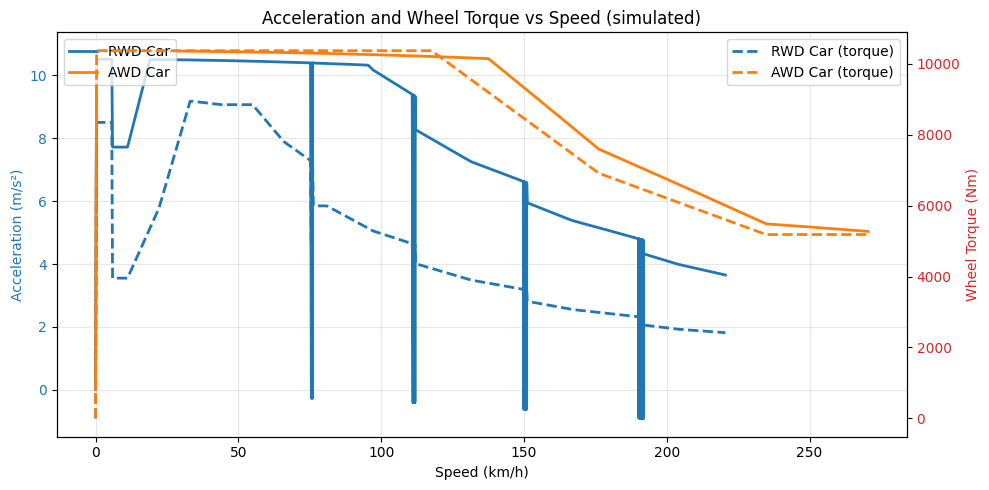

In [210]:
# 1) Acceleration behavior and wheel torque from time-simulated samples
results = {name: simulate_quarter_mile(spec, dt=dt) for name, spec in cars.items()}
fig, ax1 = plt.subplots(figsize=(10, 5))
color1 = 'tab:blue'
ax1.set_xlabel('Speed (km/h)')
ax1.set_ylabel('Acceleration (m/s²)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
for name, r in results.items():
    speed_kph = r['speed'] * 3.6
    accel = r['accel']
    order = np.argsort(speed_kph)
    ax1.plot(speed_kph[order], accel[order], label=name, linewidth=2)
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Wheel Torque (Nm)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
for name, r in results.items():
    speed_kph = r['speed'] * 3.6
    wheel_torque = r['wheel_torque']
    order = np.argsort(speed_kph)
    ax2.plot(speed_kph[order], wheel_torque[order], label=f"{name} (torque)", linestyle='--', linewidth=2)
ax1.set_title("Acceleration and Wheel Torque vs Speed (simulated)")
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

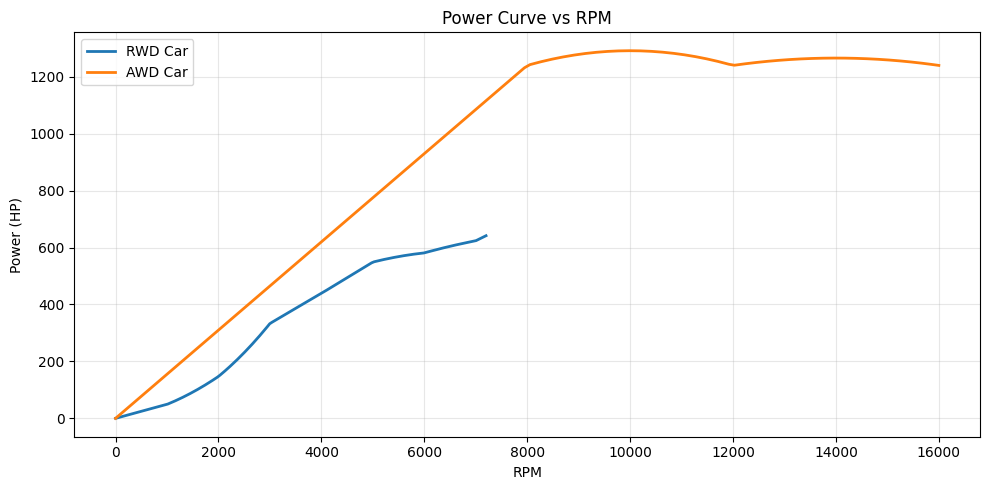

In [211]:
# 2) Power curves (HP vs RPM) for both cars
fig, ax = plt.subplots(figsize=(10, 5))
for name, car in cars.items():
    if car['powertrain_type'] == 'ICE':
        rpm_range = np.linspace(0, car['ice'].get('redline_rpm', 7000), 150)
        torques = np.array([interp_curve(car['ice']['torque_curve_rpm_nm'], rpm) for rpm in rpm_range])
        hp = (torques * rpm_range) / 7745
        ax.plot(rpm_range, hp, label=name, linewidth=2)
    elif car['powertrain_type'] == 'BEV':
        rpm_range = np.linspace(0, car['motor'].get('max_rpm', 16000), 150)
        torques = np.array([interp_curve(car['motor']['torque_curve_rpm_nm'], rpm) for rpm in rpm_range])
        hp = (torques * rpm_range) / 7745
        ax.plot(rpm_range, hp, label=name, linewidth=2)
ax.set_xlabel('RPM')
ax.set_ylabel('Power (HP)')
ax.set_title('Power Curve vs RPM')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

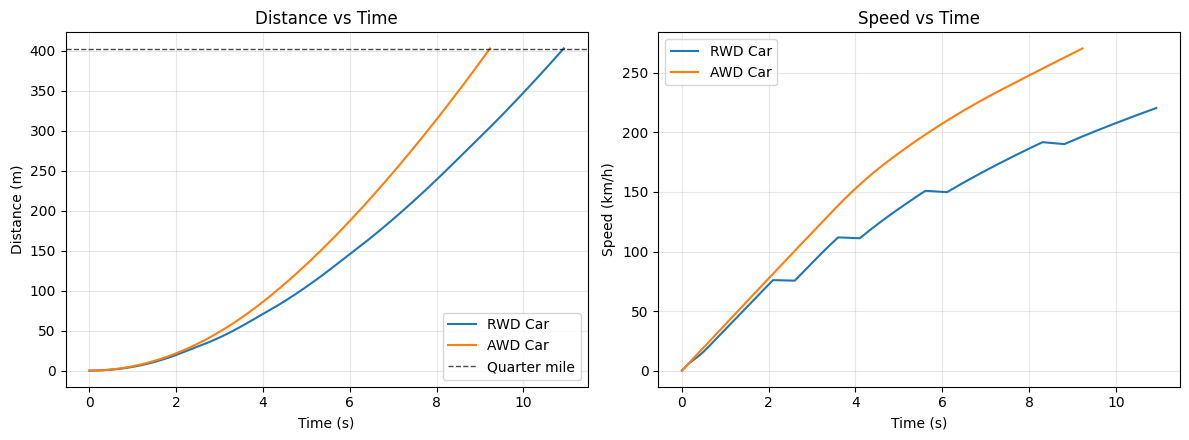

In [212]:
# 3) Race plots together: distance vs time and speed vs time
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
for name, r in results.items():
    axes[0].plot(r['time'], r['distance'], label=name)
    axes[1].plot(r['time'], r['speed'] * 3.6, label=name)
axes[0].axhline(quarter_mile_m, linestyle='--', linewidth=1.0, color='k', alpha=0.7, label='Quarter mile')
axes[0].set_title("Distance vs Time")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Distance (m)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[1].set_title("Speed vs Time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Speed (km/h)")
axes[1].grid(True, alpha=0.3)
axes[1].legend()
plt.tight_layout()
plt.show()

## Notes
- Edit `car_specs` in Cell 3 using the typed schema: `Car -> Powertrain -> Motor/Gearbox`.
- `powertrain.driving_axles` is where `RWD` / `AWD` is defined.
- `powertrain.type` is where `ICE` / `BEV` is defined.
- Manual shifts use a zero-wheel-power shift window (`gearbox.shift_time_s`).
- Wheel power includes efficiency losses and is lower than source power.